# Process meteorological data from https://api.met.no/

https://www.met.no/en/free-meteorological-data

In [1]:
from bs4 import BeautifulSoup
import urllib.request
from datetime import datetime, timedelta
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib import dates

%config InlineBackend.figure_format = 'retina'
import seaborn as sns
sns.set(style='white')

In [2]:
location_url = 'https://api.met.no/weatherapi/locationforecast/1.9/?lat=63.44&lon=10.37'

In [3]:
response = urllib.request.urlopen(location_url)
data = response.read()  
soup = BeautifulSoup(data,'lxml')

In [4]:
# Example wind dictionary
# {'beaufort': '2', 'id': 'ff', 'mps': '3.0', 'name': 'Svak vind'}

In [5]:
wind = {}
for forecast in soup.find_all(name='time'):
    if forecast.windspeed and forecast.areamaxwindspeed:
        wind[datetime.strptime(forecast.attrs['from'],'%Y-%m-%dT%H:%M:%SZ')] = [int(forecast.windspeed.attrs['beaufort']),
                                                                                float(forecast.windspeed.attrs['mps']),
                                                                                float(forecast.areamaxwindspeed.attrs['mps']),
                                                                                float(forecast.cloudiness.attrs['percent']),
                                                                                float(forecast.temperature.attrs['value'])]
        

In [6]:
wind_pd = pd.DataFrame.from_dict(wind, orient='index', columns=['bft', 'mps', 'maxwind', 'cloudiness','temperature'])

In [7]:
def plot_data(wind_pd):
    ''' Create plot from dataframe. Index has to be in timestamps'''
    sns.set(font_scale=1.1, style='white')
    figure = plt.figure(figsize=(20,4))
    ax = figure.add_subplot(111)

    ax.plot(wind_pd.index,wind_pd.bft, color='k', label='Beaufort', lw=2.5,alpha=.7)
    ax.plot(wind_pd.index,wind_pd.mps, label='m/s', ls=':', color='b')
    ax.plot(wind_pd.index,wind_pd.maxwind, label='m/s', ls=':', color='blue',alpha=.2)
    ax.set_ylabel('Wind speed')
    for time in wind_pd.index:
        if (time.hour > 20) or (time.hour < 10):
            ax.axvspan(time, time + timedelta(hours=1), alpha=0.1, color='grey', lw=0)
    ax.set_ylim(0,5.5)      
    plt.xticks(rotation='45')

    ax2 = ax.twinx()  
    ax2.plot(wind_pd.index,wind_pd.temperature, label='temperature',color='red',lw=4,alpha=.4)
    ax2.tick_params(axis='y', labelcolor='red')
    ax2.set_ylabel('Temperature [C]')

    hfmt = dates.DateFormatter('%a %H:%M')
    ax.xaxis.set_major_locator(dates.HourLocator())
    ax.xaxis.set_major_formatter(hfmt)
    ax.set_xlim(wind_pd.index[0], wind_pd.index[-1])
    
    plt.title('Wind and temperature forecast (Norwegian Meteorological Institute)', size=15)
    sns.despine(left=True)

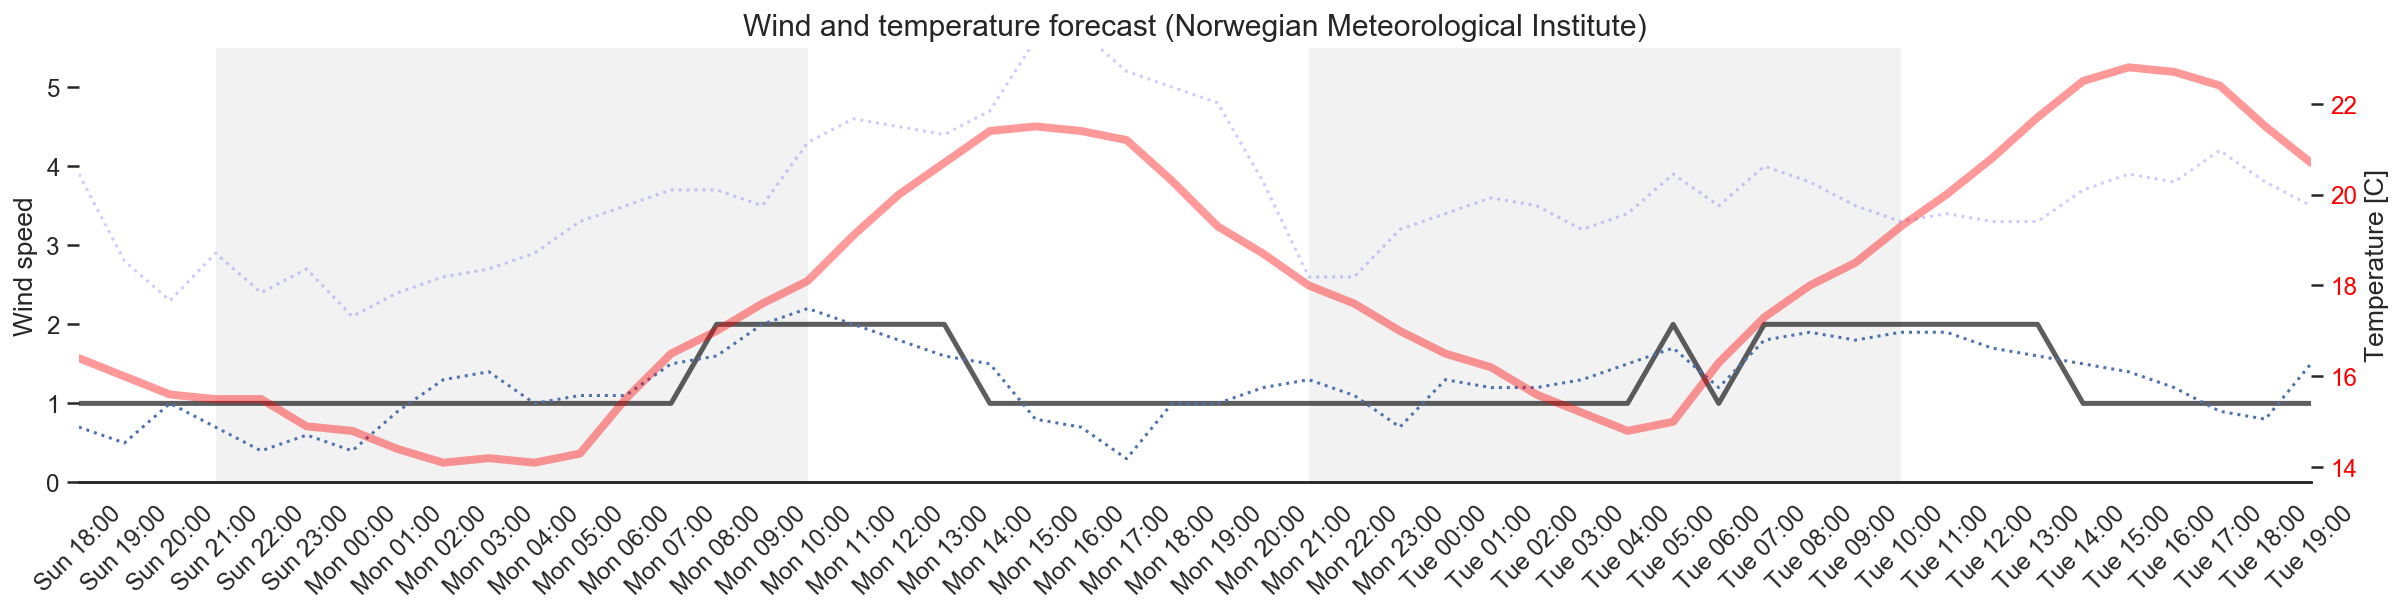

In [8]:
plot_data(wind_pd.iloc[:50])